# Topic modeling recipe ingredients with non-negative matrix factorization

Use non-negative matrix factorization to extract themes from ingredients.  

In [18]:
import pandas as pd
import numpy as np
import cPickle
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD, NMF
from numpy.random import rand, RandomState
from numpy import array, matrix, linalg
from nltk import word_tokenize 
import string
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
%matplotlib inline 

In [19]:
# Previously tokenized recipe corpus
# dict of recipe_ID:list of preprocessed, tokenized ingredient phrases
with open('../data/allrecipes/recipe_tokens.pkl', 'rb') as f: 
    recipe_tokens = cPickle.load(f)

In [20]:
recipe_tokens.items()[1]

(u'228057',
 [[u'collard', u'greens', u',', u'chopped'],
  [u')', u'package', u'hickory-smoked', u'bacon', u',', u'diced'],
  [u'butter'],
  [u'large', u'onion', u',', u'chopped'],
  [u'cubes', u'chicken', u'bouillon', u',', u'crumbled'],
  [u'water'],
  [u'garlic', u',', u'minced'],
  [u'dried', u'oregano'],
  [u'ground', u'thyme', u',', u'or', u'to', u'taste'],
  [u'dried', u'savory', u',', u'or', u'to', u'taste'],
  [u'milk']])

In [21]:
# # 
# class LemmaTokenizer(object):
#     def __init__(self):
#          self.wnl = WordNetLemmatizer()
#     def __call__(self, doc):
#          return [self.wnl.lemmatize(t) for t in word_tokenize(doc) \
#                  if t not in string.punctuation]

In [22]:
# instantiate stemmer, analyzer 
stemmer = nltk.SnowballStemmer("english")
analyzer = CountVectorizer().build_analyzer()
def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

In [23]:
# instantiate vectorizer for ingredients
vectorizer = CountVectorizer(stop_words='english', 
                             strip_accents='ascii',
                             analyzer=stemmed_words)

In [24]:
# Revert to phrases for stemming/lemmatizing purposes
X0 = [[" ".join(a) for a in b] for b in recipe_tokens.values()]

X1 = [",".join(a) for a in X0]

X2 = vectorizer.fit_transform(X1)

In [25]:
X2.shape

(11111, 2791)

In [26]:
features = vectorizer.get_feature_names()

In [27]:
def reconst_mse(target, left, right):
    return (array(target - left.dot(right))**2).mean()


In [28]:
# Explore nmf matrices 
nmf = NMF(n_components = 2)
W = nmf.fit_transform(X2)
H = nmf.components_
n_top_words = 25
print("Reconstruction error: %f") %(reconst_mse(X2, W, H))
for topic_num, topic in enumerate(H):
    print("\nTopic %d:" % topic_num)
    print(" ".join([features[i] \
            for i in topic.argsort()[:-n_top_words - 1:-1]]))

Reconstruction error: 0.009462

Topic 0:
chop pepper and to ground tast onion salt fresh garlic can black oil slice or chees dri minc dice oliv chicken tomato sauc red green

Topic 1:
sugar white flour butter egg all purpos salt bake extract vanilla ground powder milk brown cream cinnamon soften soda water packag melt chocol chees confection


## With two components, NMF appears to successfully delineate "sweet" (topic 0) and "savory" (topic 1) items.  

In [29]:
# Verify by observing recipes captured in theset topics

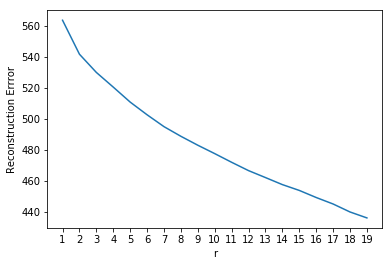

In [30]:
def fit_nmf(r):
    nmf = NMF(n_components=r)
    nmf.fit(X2)
    W = nmf.transform(X2)
    H = nmf.components_
    return nmf.reconstruction_err_

error = [fit_nmf(i) for i in range(1,20)]
plt.plot(range(1,20), error)
plt.xticks(range(1, 20))
plt.xlabel('r')
plt.ylabel('Reconstruction Errror')

In [35]:
# Obviously, the higher the dimension the lower the error.  

In [31]:
num_topics = 3
nmf = NMF(n_components=num_topics)
nmf.fit(X2) 
W = nmf.transform(X2)
H = nmf.components_
for topic_num, topic in enumerate(H):
    print("\nTopic %d:" % topic_num)
    print(" ".join([features[i] \
        for i in topic.argsort()[:-n_top_words - 1:-1]])) 


Topic 0:
chop can pepper onion and chees fresh tomato garlic green dice ground dri packag chicken slice drain shred black salt oil minc sauc red cream

Topic 1:
sugar white flour butter egg all purpos salt bake extract vanilla ground powder milk brown cream cinnamon soften soda water packag melt chocol confection chees

Topic 2:
to tast pepper or ground salt and black oil fresh garlic slice into cut oliv minc onion dri more sauc red larg chicken inch powder


## Beyond two topics, it gets harder to interpret. 

In [32]:
# instantiate vectorizer for ingredients
tfidf_vectorizer = TfidfVectorizer(stop_words='english', 
                             strip_accents='ascii',
                             analyzer=stemmed_words)
X2_tfidf = tfidf_vectorizer.fit_transform(X1)

In [33]:
tfidf_features = tfidf_vectorizer.get_feature_names()

In [34]:
# Explore nmf matrices 
nmf = NMF(n_components = 4)
W = nmf.fit_transform(X2_tfidf)
H = nmf.components_
n_top_words = 25
print("Reconstruction error: %f") %(reconst_mse(X2_tfidf, W, H))
for topic_num, topic in enumerate(H):
    print("\nTopic %d:" % topic_num)
    print(" ".join([features[i] \
            for i in topic.argsort()[:-n_top_words - 1:-1]]))

Reconstruction error: 0.000293

Topic 0:
chop pepper ground garlic dri fresh onion minc sauc oil black tomato dice red can chicken oliv green salt and bell slice powder juic vinegar

Topic 1:
sugar bake flour purpos all white extract egg vanilla butter powder soda milk salt cinnamon brown soften ground confection pack water chocol melt shorten beaten

Topic 2:
chees packag cream shred can cheddar soup of frozen mix condens sour parmesan drain grate chop mushroom slice milk thaw butter cook soften egg onion

Topic 3:
to tast or and pepper salt more slice black fresh into as need oliv cut ground oil peel potato butter larg inch lemon garlic thin


## term frequency / doc frequency might give more distinct topics.  